In [3]:
from shapely import *
import shapely.plotting as splt
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np


In [8]:
GM = (np.sqrt(5)-1.0)/2.0
W = 4
H = W*GM
SIZE = (W, H)

In [ ]:
# split room into points, create cells around each points, and determine the adjacency of these cells 

# create a room 
# create offset curve to describe surroundings, and make it into a polygon 
# use numpy to make a mesh of points that are evenly distributed 
# use buffer to create cells based on these points and the overlap/ intersection with the polygons 
# give cells properties based on their relation to the room/surroundings...
# use str tree thing to identify neighbours of each cell 

In [2]:
# create a room 
room_length = 20 #m 
room_width = 10 #m 
room_poly = box(0.0, 0.0, room_length, room_width)

In [49]:
# use buffer to describe ambient 
amb_poly = room_poly.buffer(1, cap_style="square", join_style="mitre")

In [55]:
list(room_poly.exterior.coords)

[(20.0, 0.0), (20.0, 10.0), (0.0, 10.0), (0.0, 0.0), (20.0, 0.0)]

In [57]:
room_poly.exterior.coords.xy

(array('d', [20.0, 20.0, 0.0, 0.0, 20.0]),
 array('d', [0.0, 10.0, 10.0, 0.0, 0.0]))

In [59]:
room_xy = room_poly.exterior.coords.xy

In [62]:
np.min(room_xy[0])

0.0

In [70]:
room_xy = room_poly.exterior.coords.xy

num_points = 5
x = np.linspace(np.min(room_xy[0]), np.max(room_xy[0]), num_points)
y = np.linspace(np.min(room_xy[1]), np.max(room_xy[1]), num_points)
xv, yv = np.meshgrid(x,y)

room_pts = MultiPoint([(x,y) for x,y in zip(xv.flatten(), yv.flatten())])

In [71]:
xv

array([[ 0.,  5., 10., 15., 20.],
       [ 0.,  5., 10., 15., 20.],
       [ 0.,  5., 10., 15., 20.],
       [ 0.,  5., 10., 15., 20.],
       [ 0.,  5., 10., 15., 20.]])

In [75]:
yv.flatten()

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  2.5,  2.5,  2.5,  2.5,  2.5,  5. ,
        5. ,  5. ,  5. ,  5. ,  7.5,  7.5,  7.5,  7.5,  7.5, 10. , 10. ,
       10. , 10. , 10. ])

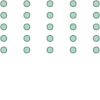

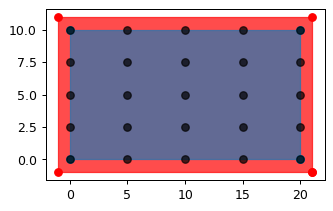

In [79]:
fig = plt.figure(figsize=SIZE,  dpi=90)
ax = fig.add_subplot(111)


splt.plot_polygon(amb_poly, ax=ax, alpha=0.7, color="red")
splt.plot_polygon(room_poly, ax=ax, alpha=0.7)

splt.plot_points(room_pts, ax=ax, alpha=0.7, color="black")